In [1]:
import torch
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange
import dill

import sys
sys.path.append("../../")

import biked_commons
from biked_commons.data_loading import data_loading
from biked_commons.resource_utils import models_and_scalers_path
from biked_commons.prediction.prediction_utils import TorchStandardScaler, DNN, Preprocessor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
X_tv, Y_tv = data_loading.load_structure_train_oh()

In [3]:
X_tv_tens = torch.tensor(X_tv.values.astype(float), dtype=torch.float32, device=device)
Y_tv_tens = torch.tensor(Y_tv.values, dtype=torch.float32, device=device)

In [4]:
scaler = TorchStandardScaler().to(device)
scaler.fit(X_tv_tens)


scaler_path = models_and_scalers_path("structural_scaler.pt")
torch.save(scaler, scaler_path)

X_tv_tens = torch.tensor(scaler.transform(X_tv_tens), dtype=torch.float32, device=device)

C:\Users\Lyler\AppData\Local\Temp\ipykernel_29052\1770829996.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tv_tens = torch.tensor(scaler.transform(X_tv_tens), dtype=torch.float32, device=device)


In [5]:
X_train, X_val, Y_train, Y_val = train_test_split(X_tv_tens, Y_tv_tens, test_size=0.2, random_state=42)

In [6]:
# Define the model, loss function, and optimizer
input_dim = X_train.shape[1]
output_dim = 6
model = DNN(input_dim, layer_sizes=(256, 128), output_dim=output_dim).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1 #500 used in benchmark
batch_size = 32
best_val_loss = float('inf')
best_model = None

bar = trange(num_epochs, desc="Training")
for epoch in bar:
    model.train()
    permutation = torch.randperm(X_train.size(0))
    for i in range(0, X_train.size(0), batch_size):
        indices = permutation[i : i + batch_size]
        batch_x, batch_y = X_train[indices], Y_train[indices]

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, Y_val)

    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        best_model = model

    bar.set_postfix({
        'loss': f'{loss.item():.4f}',
        'val_loss': f'{val_loss.item():.4f}',
        'best_val': f'{best_val_loss:.4f}'
    })



Training: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it, loss=0.6036, val_loss=0.4401, best_val=0.4401]


In [7]:
save_path = models_and_scalers_path("structural_model.pt")
# torch.save(best_model, save_path)

In [8]:
model = torch.load(save_path)

C:\Users\Lyler\AppData\Local\Temp\ipykernel_29052\1837872702.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(save_path)


In [9]:
import evaluators

evaluators.evaluate_structure(model, Preprocessor(scaler_path=scaler_path, preprocess_fn=None, device=device), device=device)

0.8484781384468079

In [10]:
Y_tv

,Mass,Planar Compliance,Transverse Compliance,Eccentric Compliance,Planar Safety Factor,Eccentric Safety Factor
11190,3.26,0.119989,0.601974,0.270555,2.4000,12.4600
3586,7.32,0.214221,0.818230,0.560876,1.6980,1.1040
3523,4.41,2.251631,1.016212,1.161965,0.6702,1.9080
5114,4.87,1.792896,1.033518,1.141831,0.7389,2.0310
2334,4.65,0.518938,1.534009,1.593069,2.7510,1.5980
...,...,...,...,...,...,...
13123,4.06,1.310991,1.421866,2.155490,0.6995,0.5077
3264,1.68,2.611128,2.305859,2.129202,0.2632,0.7364
9845,6.55,0.359746,0.545971,0.862558,1.3400,0.9617
10799,2.44,0.753192,1.977044,1.882381,0.9461,0.6515


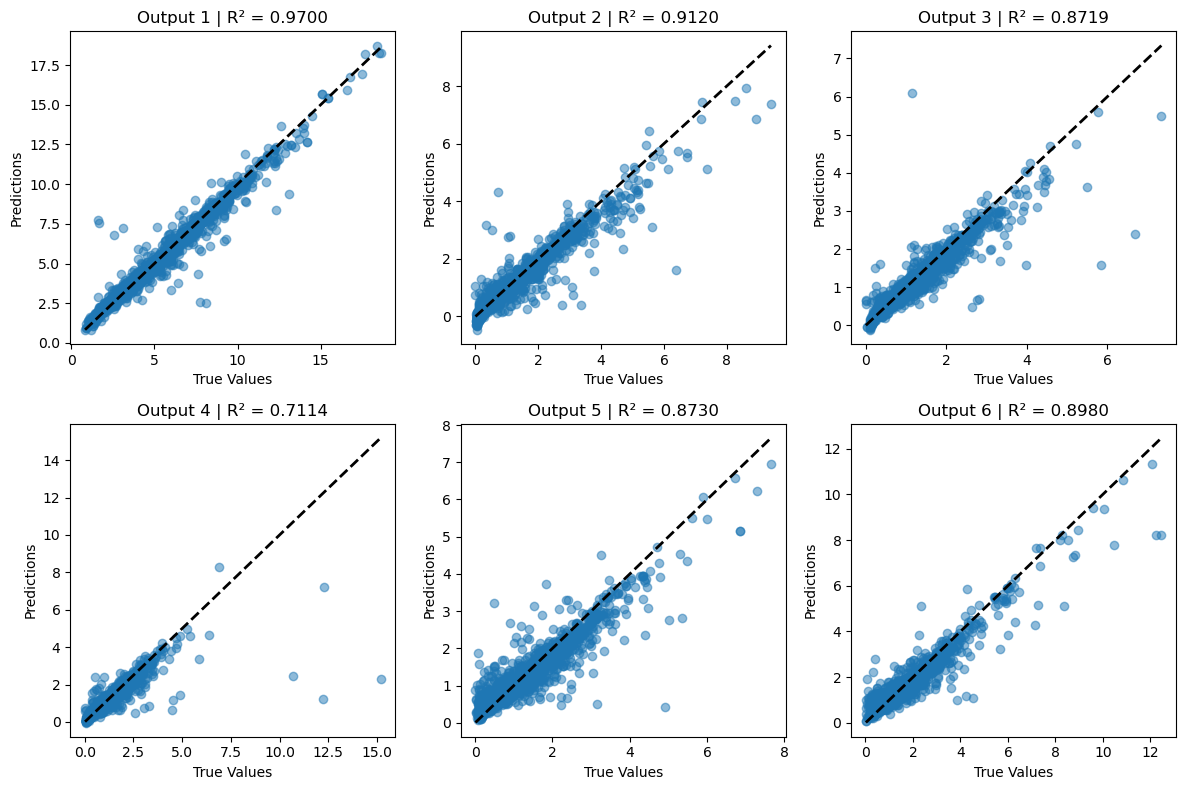

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

Y_val_npy = Y_val.cpu().detach().numpy()
val_outputs = model(X_val).cpu().detach().numpy()

num_outputs = 6
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i in range(num_outputs):
    y_true = Y_val_npy[:, i]
    y_pred = val_outputs[:, i]
    r2 = r2_score(y_true, y_pred)

    axes[i].scatter(y_true, y_pred, alpha=0.5)
    axes[i].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)
    axes[i].set_xlabel('True Values')
    axes[i].set_ylabel('Predictions')
    axes[i].set_title(f'Output {i+1} | R² = {r2:.4f}')

plt.tight_layout()
plt.show()
